In [1]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
calendar = pd.read_csv("./data/calendar.csv").pipe(reduce_mem_usage)
price = pd.read_csv("./data/sell_prices.csv").pipe(reduce_mem_usage)
sale = pd.read_csv("./data/sales_train_validation.csv").pipe(reduce_mem_usage)
submission = pd.read_csv("./data/sample_submission.csv").pipe(reduce_mem_usage)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [12]:
day_cols = [col for col in sale.columns if col.startswith("d_")]

In [20]:
start_idx = np.argmin(sale[day_cols].values == 0, axis=1)

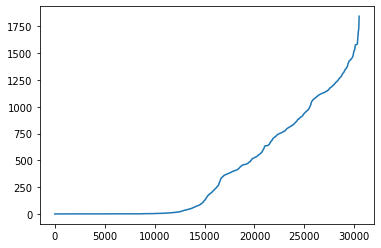

In [22]:
plt.plot(np.sort(start_idx))

In [15]:
sale[['id']+day_cols].groupby('id').apply(lambda x: np.argmin(x, axis=1))

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0


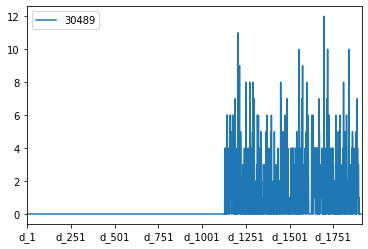

In [26]:
sale[sale.id == "FOODS_3_827_WI_3_validation"][day_cols].T.plot()

## 特征

### 时间序列状态
- 10_is_pad: 是否销售
- 10_is_zero: 是否为0销售
- 10_cum_zero: 连续销售为0第N天
- 

In [14]:
series_property = pd.DataFrame({"id": sale.id.unique()})
series_property = series_property.merge(sale[['id', 'item_id', 'dept_id', 'cat_id', 'store_id']], how='left')

In [27]:
id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sale.drop(id_cols, axis=1, inplace=True)
sale.set_index("id", inplace=True)

In [49]:
pad_end = np.argmin((sale == 0).values, axis=1)

In [52]:
is_zero = (sale == 0).values.astype(int)

for row, end in enumerate(pad_end):
    is_pad[row][:end] = 1
is_pad = np.zeros_like(sale)

In [69]:
mask_series.mean(axis=1)

masked_array(data=[0.5928853754940712, 0.27853107344632766,
                   0.3564356435643564, ..., 0.895397489539749,
                   0.7207392197125256, 1.6973180076628354],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [98]:
sale = sale.apply(np.log1p)
mask_series = np.ma.array(sale.values, mask=is_pad)

# 统计特征 skew kurt

mu = mask_series.mean(axis=1).values
std = mask_series.std(axis=1).values
q5 = np.nanpercentile(mask_series.filled(np.nan), 5)
q95 = np.nanpercentile(mask_series.filled(np.nan), 95)

# 标准化序列

sale = (sale - mu.reshape(-1, 1)) / std.reshape(-1, 1)

# lag 序列

def lag(x, n):
    r = np.zeros_like(x)
    for row in range(x.shape[0]):
        r[row, n:] = x[row, :-n]
    return r

lag30 = lag(sale.values, 30)
lag90 = lag(sale.values, 90)
lag365 = lag(sale.values, 364) * 0.25 + lag(sale.values, 365) * 0.5 + lag(sale.values, 366) * 0.25

# 价格序列
# 日期序列
# 属性特征

(30490,)

In [17]:
calendar = calendar.rename({"snap_CA": "CA", "snap_TX": "TX", "snap_WI": "WI"}, axis=1)
calendar = calendar.melt(id_vars=calendar.columns[:-3], var_name="state_id", value_name="snap")

for col in ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]:
    calendar[col] = LabelEncoder().fit_transform(calendar[col].fillna("None"))
calendar["date"] = pd.to_datetime(calendar.date)
calendar["week"] = calendar.date.dt.week

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,state_id,snap,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,19,2,3,1,CA,0,4
1,2011-01-30,11101,Sunday,2,1,2011,d_2,19,2,3,1,CA,0,4
2,2011-01-31,11101,Monday,3,1,2011,d_3,19,2,3,1,CA,0,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,19,2,3,1,CA,1,5
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,19,2,3,1,CA,1,5


In [8]:
sale.shape

(30490, 1919)

In [4]:
NUM_ITEMS = sale.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

In [5]:
for d in range(1914, 1942+DAYS_PRED):
    sale[f"d_{d}"] = np.nan

In [6]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sale = sale.melt(id_vars=id_cols, var_name="d", value_name="demand")
sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0


In [7]:
calendar = calendar.rename({"snap_CA": "CA", "snap_TX": "TX", "snap_WI": "WI"}, axis=1)
calendar = calendar.melt(id_vars=calendar.columns[:-3], var_name="state_id", value_name="snap")

In [8]:
for col in ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]:
    calendar[col] = LabelEncoder().fit_transform(calendar[col].fillna("None"))
calendar["date"] = pd.to_datetime(calendar.date)
calendar["week"] = calendar.date.dt.week

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,state_id,snap,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,19,2,3,1,CA,0,4
1,2011-01-30,11101,Sunday,2,1,2011,d_2,19,2,3,1,CA,0,4
2,2011-01-31,11101,Monday,3,1,2011,d_3,19,2,3,1,CA,0,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,19,2,3,1,CA,1,5
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,19,2,3,1,CA,1,5


In [9]:
merge = sale.merge(calendar.drop(["weekday"], axis=1), on=["d", "state_id"], how="left")
merge = merge.merge(price, on=["store_id", "item_id", "wm_yr_wk"], how="left")

In [10]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN


In [11]:
for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    merge[col] = LabelEncoder().fit_transform(merge[col])

In [12]:
merge = reduce_mem_usage(merge)

Mem. usage decreased to 3091.70 Mb (41.9% reduction)


In [13]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN


In [14]:
merge = merge.sort_values(['id', 'date']).reset_index(drop=True)

In [15]:
def drop_zero_ahead(df, col):
    first_idx = df[df[col] != 0].index[0]
    return df.iloc[first_idx:]

In [16]:
valid_merge = merge.groupby('id').apply(lambda group: drop_zero_ahead(group.reset_index(drop=True), 'demand'))

In [17]:
valid_merge = valid_merge.reset_index(drop=True)

In [18]:
valid_merge

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_1,3.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,2.000000
1,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_2,0.0,2011-01-30,11101,2,1,2011,19,2,3,1,0,4,2.000000
2,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_3,0.0,2011-01-31,11101,3,1,2011,19,2,3,1,0,5,2.000000
3,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_4,1.0,2011-02-01,11101,4,2,2011,19,2,3,1,1,5,2.000000
4,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_5,4.0,2011-02-02,11101,5,2,2011,19,2,3,1,1,5,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47649935,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1965,NaN,2016-06-15,11620,5,6,2016,19,2,3,1,1,24,5.941406
47649936,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1966,NaN,2016-06-16,11620,6,6,2016,19,2,3,1,0,24,5.941406
47649937,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1967,NaN,2016-06-17,11620,7,6,2016,19,2,3,1,0,24,5.941406
47649938,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1968,NaN,2016-06-18,11621,1,6,2016,19,2,3,1,0,24,5.941406


In [19]:
valid_merge['demand'] = np.log1p(valid_merge.demand)

In [20]:
mu = valid_merge.groupby('id')['demand'].mean().rename("mu")

In [21]:
std = valid_merge.groupby('id')['demand'].std().rename("std")

In [22]:
standar = pd.DataFrame(valid_merge['id']).merge(mu, on='id', how='left').merge(std, on='id', how='left')

In [25]:
valid_merge['demand'] = (valid_merge.demand.values - standar['mu'].values) / standar['std'].values

In [29]:
train = valid_merge[valid_merge.demand.notnull()]

In [ ]:
data = MultiSeriesData(x=train.demand.values.reshape(-1, 1), enc_len=365, dec_len=28, series_id=train.id)

In [79]:
from bokeh.plotting import figure, output_file, show

# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# output to static HTML file
output_file("lines.html")

# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# add a line renderer with legend and line thickness
p.line(x, y, legend_label="Temp.", line_width=2)

# show the results
show(p)

In [80]:
p

Figure(id='1001', ...)